# Age and Gender classification
# Exploratory Data Analysis of the Extended Dataset

## Data Analysis

### Environment setup

In [1]:
import sys
import os
sys.path
sys.path.append('..')
import shutil

import pandas as pd
import numpy as np
import re
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.decomposition import IncrementalPCA

from utils import load_class_data
from utils import plot_image_dimensions
from utils import capture_faces_fan, capture_faces_mtcnn, display_images_no_faces
from utils import load_images_as_flattened_array, plot_principal_components_as_images
from utils import plot_pie_chart, plot_age_distribution_line, plot_age_barplots
from utils import plot_grouped_bar
from utils import age_group_labels_UTK

import warnings
warnings.filterwarnings("ignore", module="face_alignment")

import torch
print(f"Is CUDA available: {torch.cuda.is_available()}")

Is CUDA available: True


### Importing the Data and Checking for missing Values

In [2]:
path_data = '../data/merged'

In [3]:
df_labels = pd.read_csv('../data/merged/df_labels_cleaned.csv')

In [4]:
df_labels.shape

(100985, 4)

In [5]:
print(df_labels[df_labels[['age_group', 'gender', 'race']].isna().any(axis=1)])

Empty DataFrame
Columns: [filename, gender, race, age_group]
Index: []


### Image Dimensions

In this part, we analyze the dimensions of the images in our dataset to ensure consistency in image size, which is critical for model performance and preprocessing. We extract the width and height of each image and plot a scatterplot of the dimensions.

The scatterplot shows that all images have a uniform size of 200x200 pixels

Gathering image dimensions: 100%|████████████████████████████████████████████| 100985/100985 [00:30<00:00, 3339.09it/s]


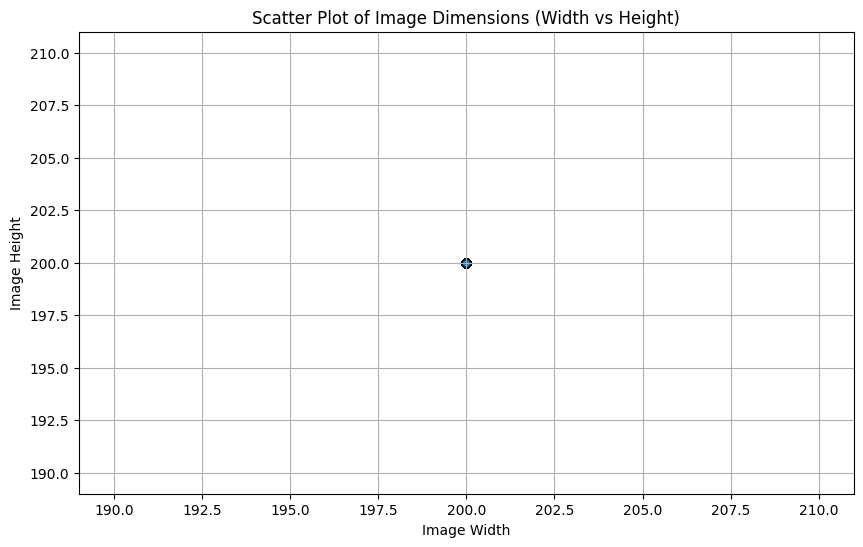

In [6]:
plot_image_dimensions(path_data, df_labels)

### Content of the Image

To ensure that the images in our dataset contain identifiable faces, we applied face detection procedure. This method was applied to confirm the presence of faces in each image within our dataset, which is crucial for the success of our face-based classification tasks.

In [7]:
df_labels_with_faces = capture_faces_fan(path_data, df_labels)

Processing faces with FAN: 100%|███████████████████████████████████████████████| 100985/100985 [56:57<00:00, 29.55it/s]


If the FAN model detected a face in an image, the image was marked as containing a face (face_found = 1). If no face was detected, it was marked as having no face (face_found = 0).

In [8]:
df_labels_with_faces_extended = capture_faces_mtcnn(path_data, df_labels)

Processing faces with MTCNN: 100%|█████████████████████████████████████████████| 100985/100985 [29:20<00:00, 57.37it/s]


If the MTCNN model detected a face in an image, the image was marked as containing a face (face_found_mtcnn = 1). If no face was detected, it was marked as having no face (face_found_mtcnn = 0).

In [9]:
df_labels_recognized = pd.merge(
    df_labels_with_faces_extended,
    df_labels_with_faces,
    on=['filename', 'age_group', 'gender', 'race'],
    how='inner',
    suffixes=('_extended', '_original')
)

print(df_labels_recognized.sample(5))

                  filename  gender  race  age_group  face_found_mtcnn  \
79100  face75934_0_3_3.jpg       0     3          3                 1   
68484  face64319_0_2_1.jpg       0     2          1                 1   
33382  face25801_1_3_1.jpg       1     3          1                 1   
68758  face64612_1_2_5.jpg       1     2          5                 1   
85112  face82534_1_4_3.jpg       1     4          3                 1   

       face_found  
79100           1  
68484           1  
33382           1  
68758           1  
85112           1  


In [10]:
face_found_counts = df_labels_recognized['face_found'].value_counts()
face_found_mtcnn_counts = df_labels_recognized['face_found_mtcnn'].value_counts()

print("Counts in 'face_found':")
print(face_found_counts)
print("\nCounts in 'face_found_mtcnn':")
print(face_found_mtcnn_counts)

Counts in 'face_found':
face_found
1    100985
Name: count, dtype: int64

Counts in 'face_found_mtcnn':
face_found_mtcnn
1    100985
Name: count, dtype: int64


**Creating a checkpoint.**

In [11]:
output_path = '../data/merged/df_labels_recognized.csv'
df_labels_recognized.to_csv(output_path, index=False)

print(f"DataFrame saved.")

DataFrame saved.


In [12]:
df_labels_recognized = pd.read_csv(output_path)

### Images with failed Face Recognition

In this part of the project, we evaluate the success of face recognition across the images in our dataset using two face detection models: FAN and MTCNN. We are interested in identifying cases where either model fails to detect a face or detects an unexpected number of faces (more than one).

In [13]:
FAN_column = "face_found"

In [14]:
MTCNN_column = "face_found_mtcnn"

Using these columns, we categorize and count specific cases:

* Rows where both models found 0 faces: This scenario indicates complete face detection failure by both models.
* Rows where both models found more than 1 face: This suggests multiple face detections, which is unexpected for this dataset.
* Rows where only FAN found 0 or more than 1 face: FAN either failed to detect a face or detected multiple faces, while MTCNN succeeded in detecting a single face.
* Rows where only MTCNN found 0 or more than 1 face: MTCNN either failed to detect a face or detected multiple faces, while FAN succeeded in detecting a single face.

The output of this analysis shows that there are no instances where either model failed or detected multiple faces, indicating high accuracy and consistency in face detection for this dataset.

In [15]:
both_zero = df_labels_recognized[(df_labels_recognized['face_found'] == 0) & (df_labels_recognized['face_found_mtcnn'] == 0)]
both_more_than_one = df_labels_recognized[(df_labels_recognized['face_found'] > 1) & (df_labels_recognized['face_found_mtcnn'] > 1)]
only_face_found_zero_or_more_than_one = df_labels_recognized[
    (df_labels_recognized['face_found'] == 0) | (df_labels_recognized['face_found'] > 1)
]
only_face_found_mtcnn_zero_or_more_than_one = df_labels_recognized[
    (df_labels_recognized['face_found_mtcnn'] == 0) | (df_labels_recognized['face_found_mtcnn'] > 1)
]

print("Rows where both models found 0 faces:", len(both_zero))
print("Rows where both models found more than 1 face:", len(both_more_than_one))
print("Rows where only FAN found 0 or more than 1 face:", len(only_face_found_zero_or_more_than_one))
print("Rows where only MTCNN found 0 or more than 1 face:", len(only_face_found_mtcnn_zero_or_more_than_one))

Rows where both models found 0 faces: 0
Rows where both models found more than 1 face: 0
Rows where only FAN found 0 or more than 1 face: 0
Rows where only MTCNN found 0 or more than 1 face: 0


In [18]:
df_labels_recognized = df_labels_recognized[df_labels_recognized['models_recognized'] == 1].reset_index(drop=True)
print(f"Cleaned dataset shape: {df_labels_recognized.shape}")

Cleaned dataset shape: (100985, 7)


### PCA for Image Feature Evaluation

In this section, we apply Principal Component Analysis (PCA) to a subset of images to ensure that the preprocessing effectively preserves the essential facial information needed for model training. PCA is a dimensionality reduction technique that transforms the original data into a set of linearly uncorrelated components, called principal components, which capture the most significant patterns in the data.

By conducting PCA, we aim to verify that the images retain the critical facial features in an organized manner, optimizing them for the model to easily access relevant information. This step helps us confirm that our preprocessing pipeline structures the data in a way that facilitates effective learning, ensuring that important facial characteristics are preserved and readily accessible for the trained model.

In [22]:
n_components = 30
batch_size = 100

ipca = IncrementalPCA(n_components=n_components)

num_images = len(df_labels_recognized)
for i in tqdm(range(0, num_images, batch_size), desc="Processing Batches"):
    batch_images = load_images_as_flattened_array(path_data, df_labels_recognized.iloc[i:i + batch_size])
    
    ipca.partial_fit(batch_images)

Processing Batches: 100%|██████████████████████████████████████████████████████████| 1010/1010 [09:29<00:00,  1.77it/s]


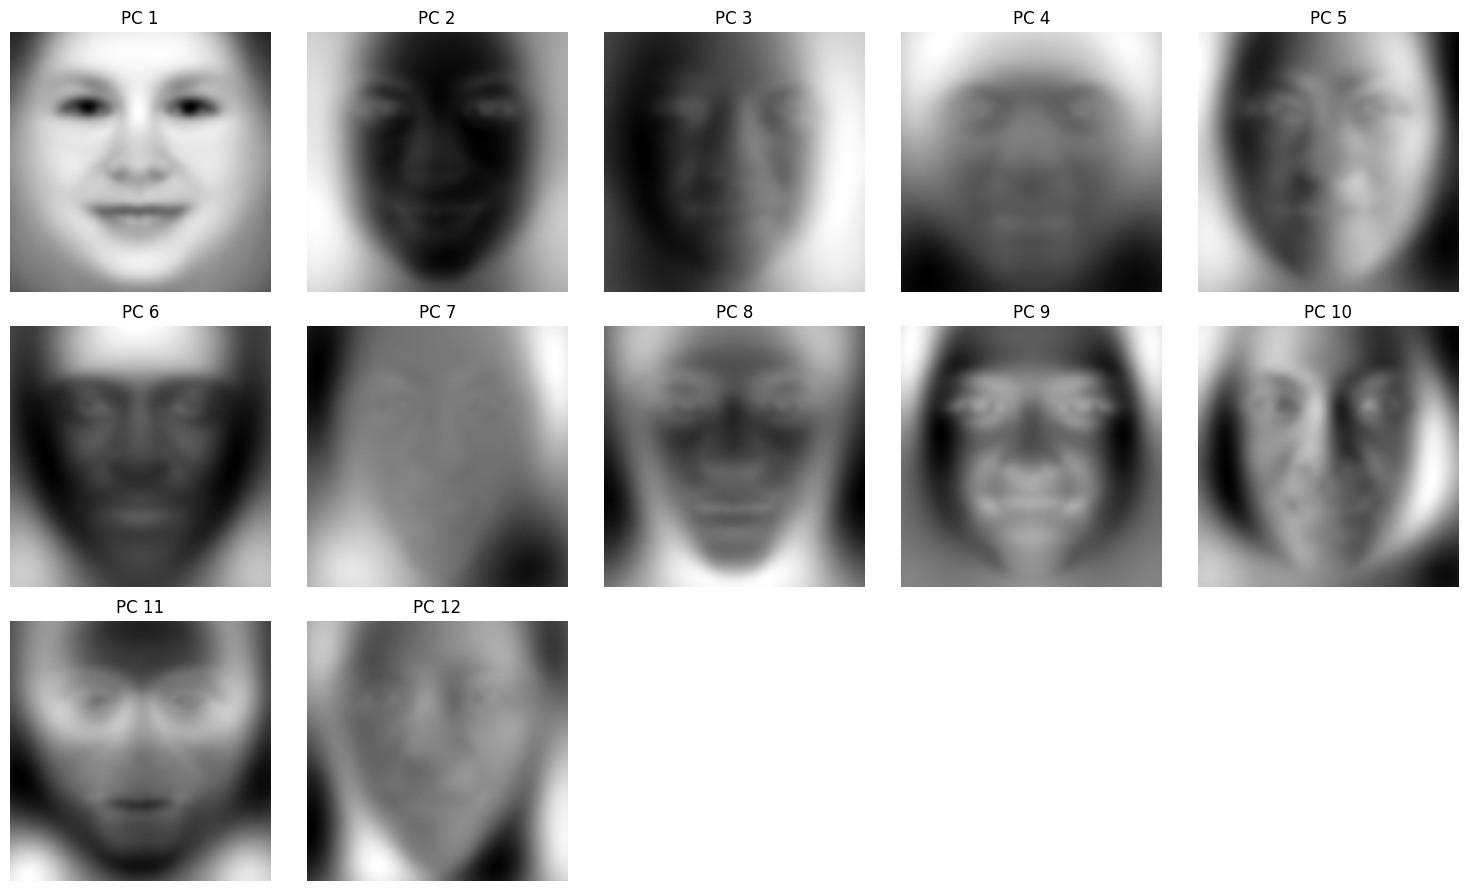

In [23]:
plot_principal_components_as_images(ipca, num_components=12)

PCA reveals that the dataset captures essential facial features and provides well-defined variations that can be useful for model training. The presence of distinct principal components indicates that the data has sufficient diversity in terms of face shapes, expressions, and other key facial characteristics.

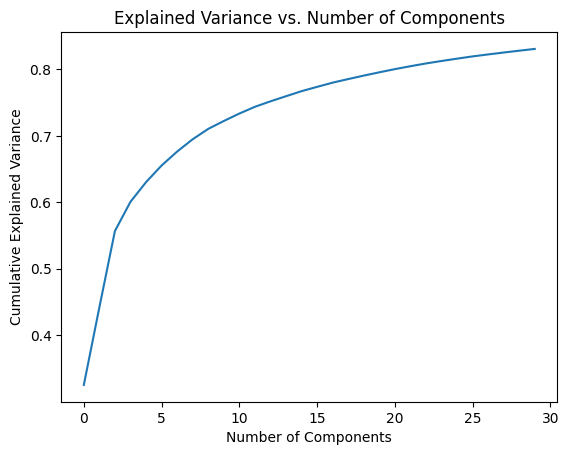

In [24]:
plt.plot(np.cumsum(ipca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

* The first few principal components capture a significant amount of variance, with around 10 components capturing approximately 75% of the total variance.
* After about 15 components, the explained variance increase slows down, indicating diminishing returns with additional components.
* Around 30 components, the cumulative explained variance approaches 85%, meaning that this number of components retains most of the important information from the data.

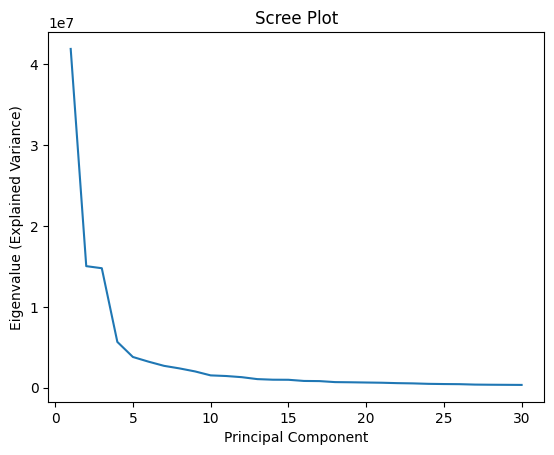

In [25]:
plt.plot(range(1, len(ipca.explained_variance_)+1), ipca.explained_variance_)
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue (Explained Variance)')
plt.title('Scree Plot')
plt.show()

After about 10 components, additional components contribute very little to explaining variance.

This suggests that selecting the first 10 components would capture most of the important information, while adding more components beyond this point yields diminishing returns.

### Labels Analysis

In this section, we explore the key demographic labels in the dataset—age, gender, and race. Understanding the distribution of these labels is essential for building an accurate and fair multi-label classification model. 

#### Gender Labels

In [26]:
gender_labels = {0: 'Male', 1: 'Female'}

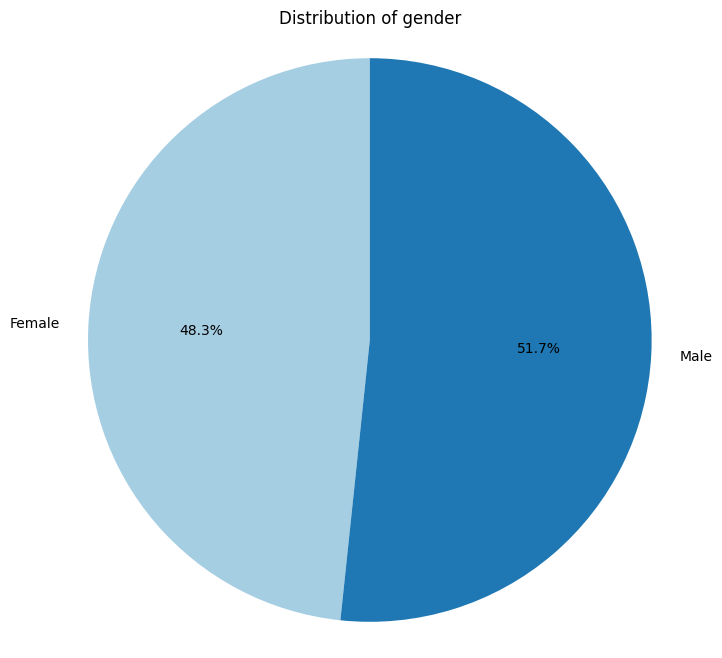

In [27]:
plot_pie_chart(df_labels_recognized, 'gender', label_dict=gender_labels)

The pie chart above illustrates the gender distribution in the dataset. The dataset shows a relatively balanced distribution between males and females, with males constituting 51.7% and females making up 48.3% of the dataset. This near-equal distribution is ideal for ensuring that the model training process does not heavily favor one gender over the other, potentially improving the generalizability and fairness of the model in gender-related predictions.

#### Race Labels

In [28]:
race_labels = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

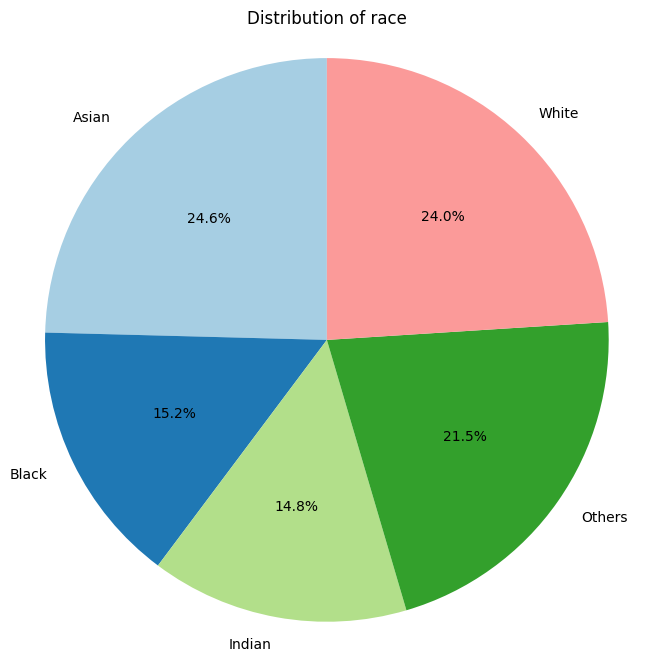

In [29]:
plot_pie_chart(df_labels_recognized, 'race', label_dict=race_labels)

The pie chart above presents the race distribution within the dataset. The largest group is "Asian," making up 24.6% of the data, followed by "White" at 24.0%, "Others" (including Hispanic, Latino, Middle Eastern, etc.) representing 21.5%, "Black" at 15.2%, and "Indian" at 14.8%. This distribution shows diversity across racial categories, although "Asian" is the most dominant group. This variety ensures that models can be trained to generalize across different ethnicities.

#### Age Group in the Data

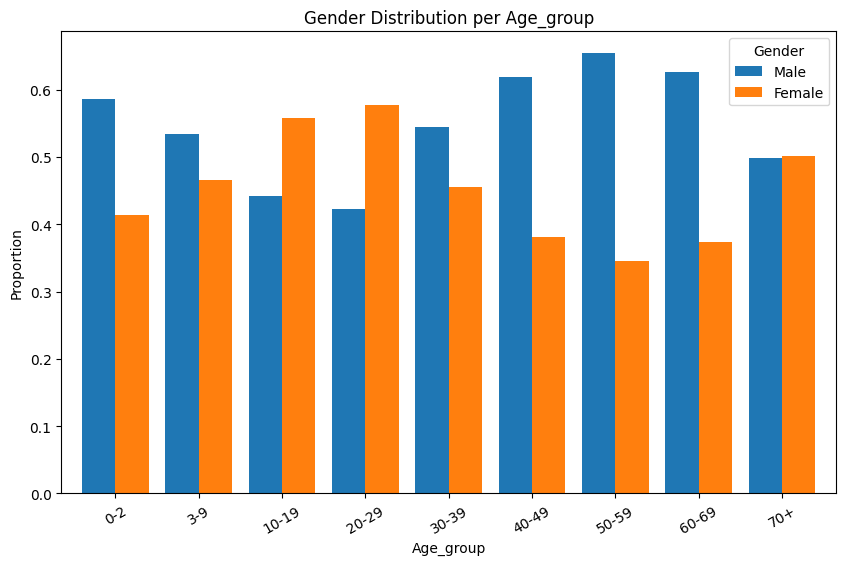

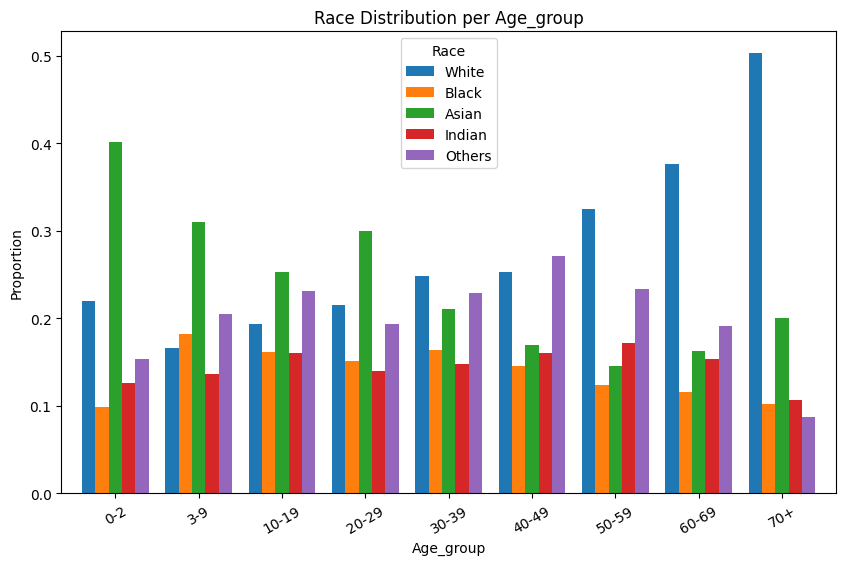

In [35]:
plot_grouped_bar(df_labels_recognized, 'age_group', 'gender', age_group_labels, gender_labels)
plot_grouped_bar(df_labels_recognized, 'age_group', 'race', age_group_labels, race_labels)

**Gender Distribution per Age Group**:

* The gender distribution shows variability across age groups. Males dominate the 40-49 and 50-59 age groups, with more than 60% representation. However, females slightly outnumber males in the younger age groups, particularly in the 3-9 and 20-29 age groups. The 0-2, 10-19, and 30-39 age groups show more balanced proportions of males and females.
* In the older age group (70+), males are still more prominent but with a reduced margin compared to middle age groups.

**Race Distribution per Age Group**:

* The race distribution highlights significant variation across age groups. The White group shows higher representation in older age groups, especially 50-59, 60-69, and 70+.
* The Indian and Black groups have consistent representation across younger age groups (0-2, 3-9, 10-19), but their representation decreases in older age brackets.
* The "Others" category displays a relatively even distribution across most age groups, with a slight increase in middle to older age groups (40-49, 50-59).
* Asians are more prominent in younger age groups but show reduced representation in older brackets.

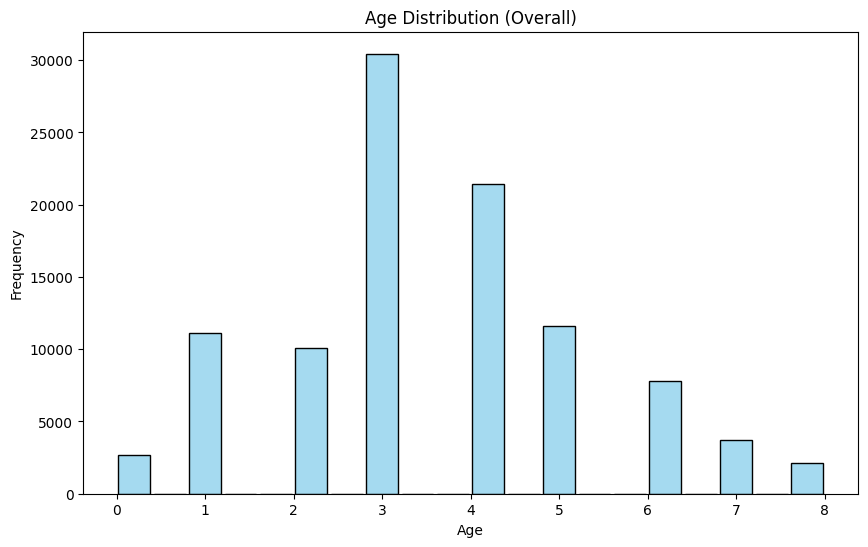

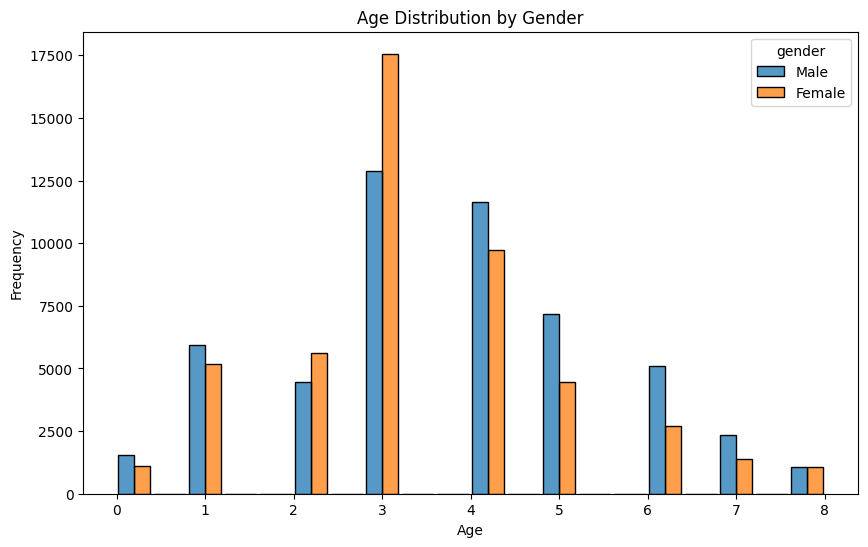

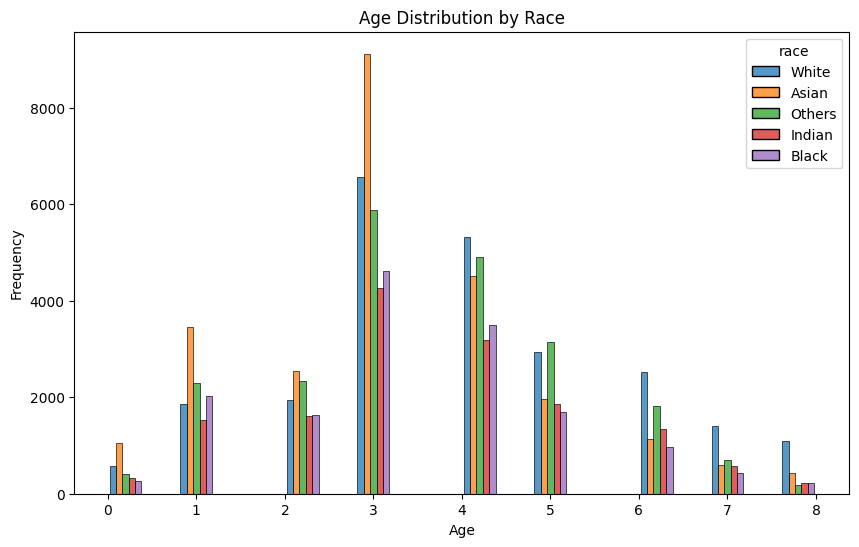

In [31]:
plot_age_barplots(df_labels_recognized, 'age_group', 'gender', 'race', gender_labels, race_labels)

The age distribution graphs offer key insights into the dataset:

**Overall Age Distribution**:

* The dataset is heavily concentrated in the age groups 20-29. This suggests a strong presence of midle aged individuals.
* There is a steady decline in the number of individuals as the age groups increase, with the least representation in the 70+ age group.

**Age Distribution by Gender**: 
* The 20-29 age group has a higher proportion of females compared to males, while males become more prominent in older age groups, particularly in 40-49 and 50-59.
* In the 70+ group, the gender distribution becomes closer to parity, with males still slightly more represented.

**Age Distribution by Race**:

* The 10-19 age group show the most racial diversity, with high representation from Asian, White, and Other racial groups.

* The White population shows stronger representation in the older age groups (50-59 and 60-69), while Asian and Other groups are more concentrated in younger age brackets.

* The 70+ age group is predominantly White, with much lower representation from other racial groups, highlighting a potential generational demographic shift. 

In summary, the dataset has a strong representation of 20-29 age group individuals, especially females, and there are notable differences in age distribution among the different races, with white individuals having a broader age range.

In [37]:
cleaned_dataset_labels = df_labels_recognized.drop(columns=['face_found_mtcnn', 'face_found', 'models_recognized'])

In [39]:
output_path = '../data/merged/dataset_labels.csv'
cleaned_dataset_labels.to_csv(output_path, index=False)
